VGG16 without Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (224, 224)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=38, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

train_accuracy = history.history['accuracy'][-1]
test_accuracy = model.evaluate(test_data_generator)[1]
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


Epoch 1/10
23/23 [==============================] - 158s 7s/step - loss: 0.8544 - accuracy: 0.4972 - val_loss: 0.6812 - val_accuracy: 0.5500
Epoch 2/10
23/23 [==============================] - 138s 6s/step - loss: 0.8756 - accuracy: 0.4958 - val_loss: 0.6501 - val_accuracy: 0.5500
Epoch 3/10
23/23 [==============================] - 147s 6s/step - loss: 0.7959 - accuracy: 0.5590 - val_loss: 0.6284 - val_accuracy: 0.5500
Epoch 4/10
23/23 [==============================] - 153s 7s/step - loss: 0.7864 - accuracy: 0.5520 - val_loss: 0.6068 - val_accuracy: 0.5500
Epoch 5/10
23/23 [==============================] - 156s 7s/step - loss: 0.7726 - accuracy: 0.5562 - val_loss: 0.5818 - val_accuracy: 0.6250
Epoch 6/10
23/23 [==============================] - 144s 7s/step - loss: 0.7449 - accuracy: 0.5983 - val_loss: 0.5593 - val_accuracy: 0.6875
Epoch 7/10
23/23 [==============================] - 152s 7s/step - loss: 0.7296 - accuracy: 0.6053 - val_loss: 0.5414 - val_accuracy: 0.7000
Epoch 8/10
23

7/7 [==============================] - 41s 6s/step


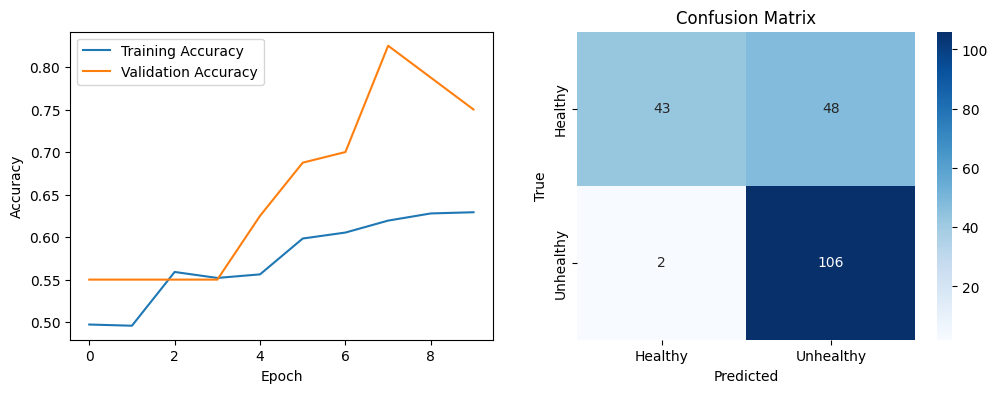


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      0.47      0.63        91
   Unhealthy       0.69      0.98      0.81       108

    accuracy                           0.75       199
   macro avg       0.82      0.73      0.72       199
weighted avg       0.81      0.75      0.73       199



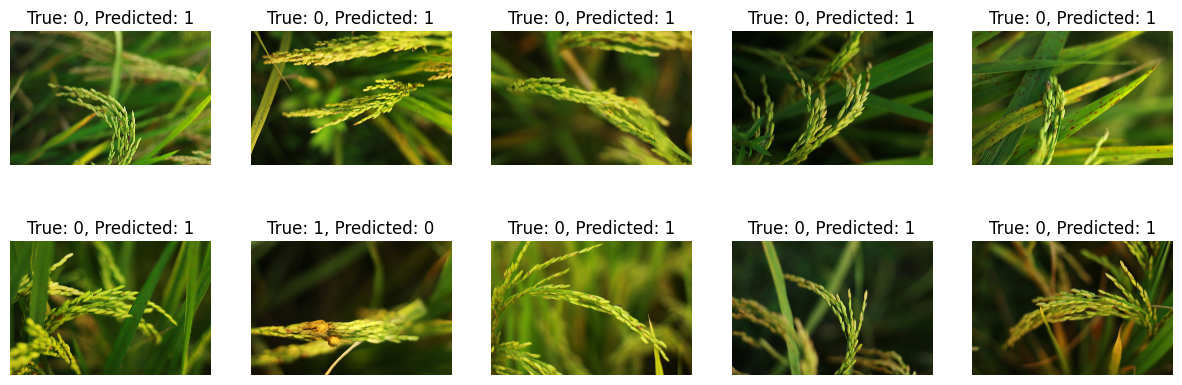

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()

VGG16 with Augmentation

In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder


In [ ]:

data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (224, 224)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

label_encoder = LabelEncoder()
train_labels_indices = label_encoder.fit_transform(train_labels)

class_weights = compute_sample_weight('balanced', train_labels_indices)
class_weight_dict = {class_index: weight for class_index, weight in zip(np.unique(train_labels_indices), class_weights)}

print("Class Weights:", class_weight_dict)

datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_generator = train_data_generator.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=True
)

val_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=False
)
test_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=False
)

Class Weights: {0: 0.9198966408268734, 1: 0.9198966408268734}
Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

test_accuracy = model.evaluate(test_data_generator)[1]
print("Testing Accuracy:", test_accuracy)



Epoch 1/10
23/23 [==============================] - 166s 7s/step - loss: 0.8235 - accuracy: 0.5225 - val_loss: 0.6737 - val_accuracy: 0.5500
Epoch 2/10
23/23 [==============================] - 163s 7s/step - loss: 0.8375 - accuracy: 0.5211 - val_loss: 0.6315 - val_accuracy: 0.5500
Epoch 3/10
23/23 [==============================] - 162s 7s/step - loss: 0.7555 - accuracy: 0.5604 - val_loss: 0.5686 - val_accuracy: 0.6000
Epoch 4/10
23/23 [==============================] - 157s 7s/step - loss: 0.6909 - accuracy: 0.6011 - val_loss: 0.4936 - val_accuracy: 0.8625
Epoch 5/10
23/23 [==============================] - 156s 7s/step - loss: 0.6193 - accuracy: 0.6601 - val_loss: 0.4241 - val_accuracy: 0.8375
Epoch 6/10
23/23 [==============================] - 155s 7s/step - loss: 0.5276 - accuracy: 0.7416 - val_loss: 0.3405 - val_accuracy: 0.8875
Epoch 7/10
23/23 [==============================] - 159s 7s/step - loss: 0.4784 - accuracy: 0.7640 - val_loss: 0.2612 - val_accuracy: 0.9250
Epoch 8/10
23

7/7 [==============================] - 35s 5s/step


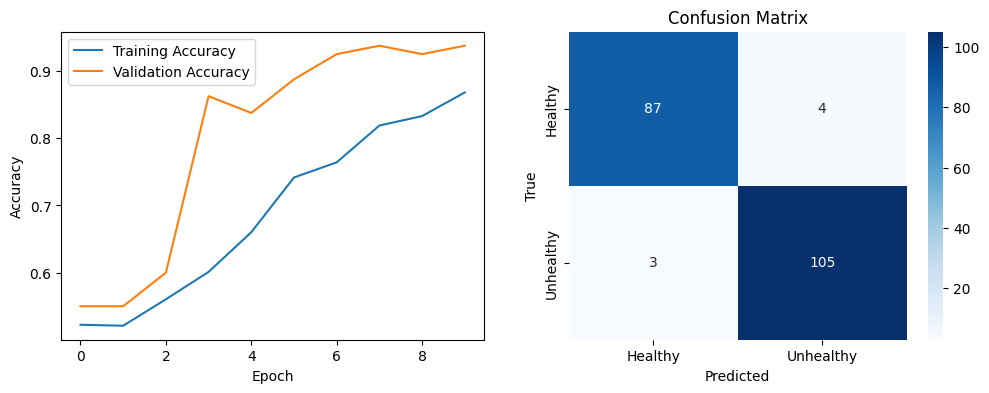


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.96        91
   Unhealthy       0.96      0.97      0.97       108

    accuracy                           0.96       199
   macro avg       0.96      0.96      0.96       199
weighted avg       0.96      0.96      0.96       199



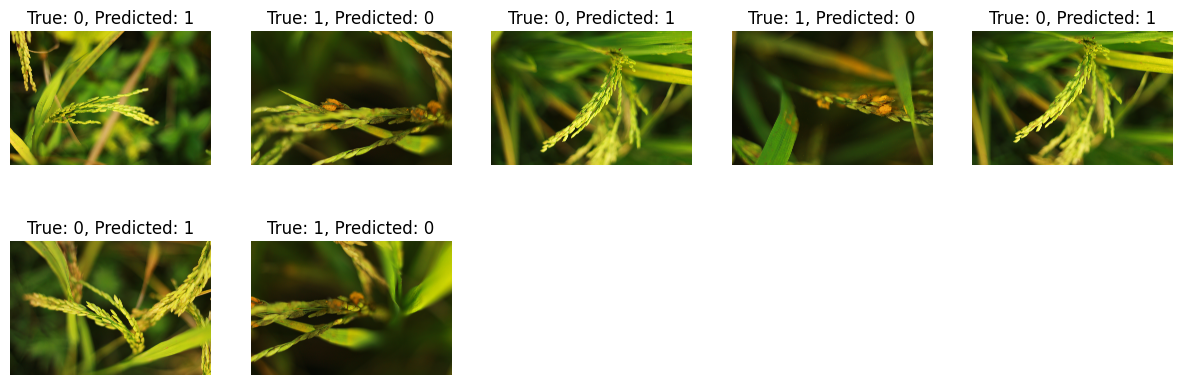

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/thesis colabs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/thesis colabs.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_batch / 255.0
    return img_preprocessed

new_image_path = '/content/drive/MyDrive/thesis all/thesis dataset/Unhealthy/20231111151309_IMG_8066 (1).JPG'

img_preprocessed = preprocess_image(new_image_path)

predictions = model.predict(img_preprocessed)

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = label_encoder.classes_[predicted_class_index]

print("Predicted Class:", predicted_class_label)


1/1 [==============================] - 0s 150ms/step
Predicted Class: Unhealthy


VGG19 without Augmentation

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:
data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (224, 224)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

train_accuracy = history.history['accuracy'][-1]
test_accuracy = model.evaluate(test_data_generator)[1]
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
23/23 [==============================] - 318s 13s/step - loss: 0.8837 - accuracy: 0.5225 - val_loss: 0.6618 - val_accuracy: 0.5500
Epoch 2/10
23/23 [==============================] - 172s 8s/step - loss: 0.8466 - accuracy: 0.5351 - val_loss: 0.6463 - val_accuracy: 0.5500
Epoch 3/10
23/23 [==============================] - 169s 7s/step - loss: 0.8199 - accuracy: 0.5323 - val_loss: 0.6191 - val_accuracy: 0.7125
Epoch 4/10
23/23 [==============================] - 167s 7s/step - loss: 0.8287 - accuracy: 0.5365 - val_loss: 0.6047 - val_accuracy: 0.6250
Epoch 5/10
23/23 [==============================] - 164s 7s/step - loss: 0.7669 - accuracy: 0.5604 - val_loss: 0.5875 - val_accuracy: 0.6500
Epoch 6/10
23/23 [==============================] - 156s 7s/step - loss: 0.7902 - accuracy: 0.5758 - val_loss: 0.5761 - val_accuracy: 0.6375
Epoch 7/10
23/23 [==============================] - 152s 7s/step - loss: 0.7668 - accura

7/7 [==============================] - 39s 5s/step


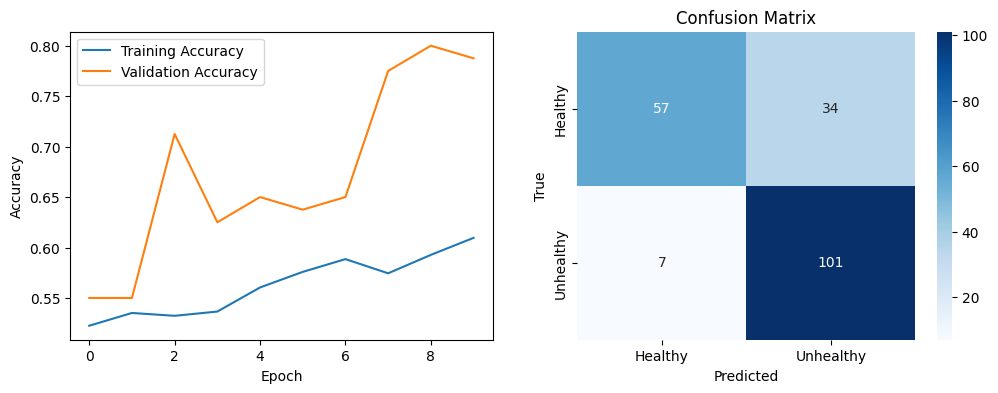


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.89      0.63      0.74        91
   Unhealthy       0.75      0.94      0.83       108

    accuracy                           0.79       199
   macro avg       0.82      0.78      0.78       199
weighted avg       0.81      0.79      0.79       199



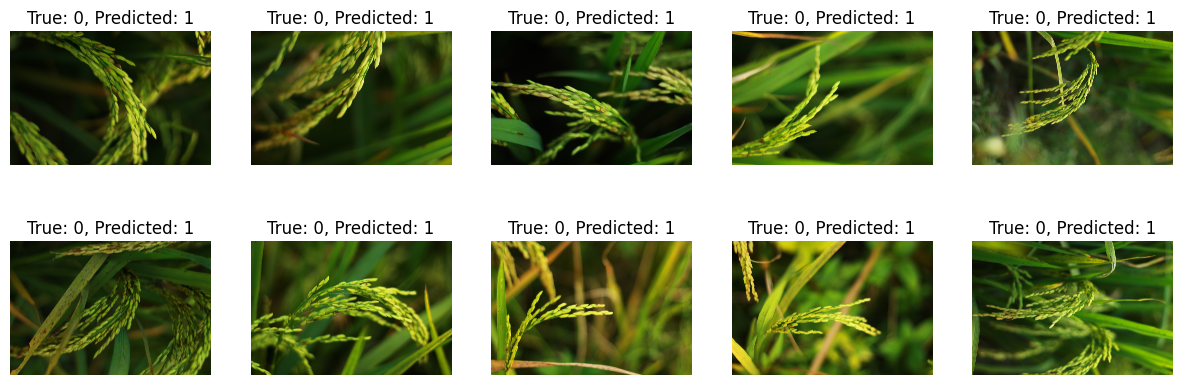

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()

VGG19 With Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder


In [ ]:

data_path = '/content/drive/MyDrive/Thesis Dataset'
img_size = (224, 224)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

label_encoder = LabelEncoder()
train_labels_indices = label_encoder.fit_transform(train_labels)

class_weights = compute_sample_weight('balanced', train_labels_indices)
class_weight_dict = {class_index: weight for class_index, weight in zip(np.unique(train_labels_indices), class_weights)}

print("Class Weights:", class_weight_dict)

datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_generator = train_data_generator.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=True
)

val_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=False
)
test_data_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    class_indices=dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    shuffle=False
)

Class Weights: {0: 0.9198966408268734, 1: 0.9198966408268734}
Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

for layer in base_model.layers[-4:]:
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=13,
    validation_data=val_data_generator,
    class_weight=class_weight_dict
)

train_accuracy = history.history['accuracy'][-1]
test_accuracy = model.evaluate(test_data_generator)[1]
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/13
23/23 [==============================] - 384s 15s/step - loss: 0.8371 - accuracy: 0.5028 - val_loss: 0.6061 - val_accuracy: 0.6625
Epoch 2/13
23/23 [==============================] - 176s 8s/step - loss: 0.6508 - accuracy: 0.6025 - val_loss: 0.4391 - val_accuracy: 0.8750
Epoch 3/13
23/23 [==============================] - 175s 8s/step - loss: 0.4604 - accuracy: 0.7654 - val_loss: 0.2852 - val_accuracy: 0.9375
Epoch 4/13
23/23 [==============================] - 175s 8s/step - loss: 0.2972 - accuracy: 0.8483 - val_loss: 0.1857 - val_accuracy: 0.9125
Epoch 5/13
23/23 [==============================] - 172s 7s/step - loss: 0.2822 - accuracy: 0.8862 - val_loss: 0.2563 - val_accuracy: 0.8500
Epoch 6/13
23/23 [==============================] - 168s 7s/step - loss: 0.2091 - accuracy: 0.9185 - val_loss: 0.1874 - val_accuracy: 0.9125
Epoch 7/13
23/23 [==============================] - 170s 7s/step - loss: 0.1851 - accura

7/7 [==============================] - 37s 5s/step


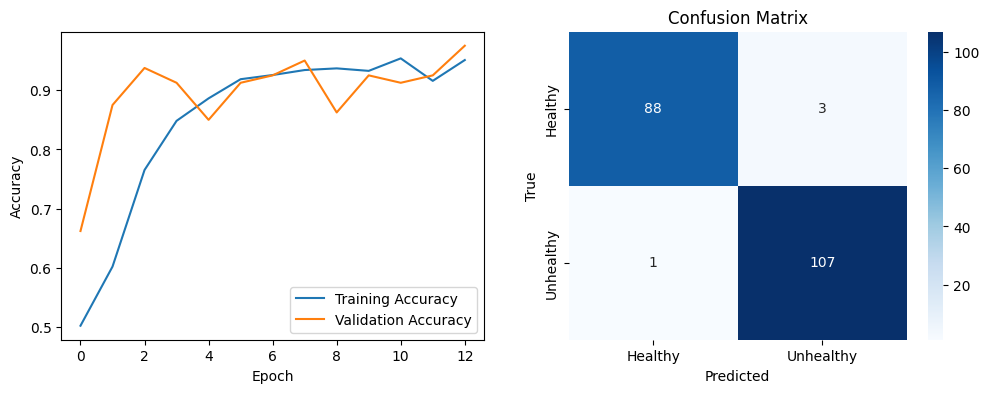


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98        91
   Unhealthy       0.97      0.99      0.98       108

    accuracy                           0.98       199
   macro avg       0.98      0.98      0.98       199
weighted avg       0.98      0.98      0.98       199



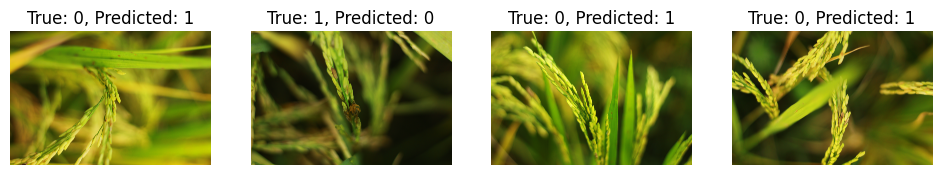

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/thesis colabs/vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/thesis colabs/vgg19.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_batch / 255.0
    return img_preprocessed

new_image_path = '/content/drive/MyDrive/Thesis Dataset/Healthy/20231111191300_IMG_8650.JPG'

img_preprocessed = preprocess_image(new_image_path)

predictions = model.predict(img_preprocessed)

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = label_encoder.classes_[predicted_class_index]

print("Predicted Class:", predicted_class_label)


1/1 [==============================] - 0s 165ms/step
Predicted Class: Healthy
